In [44]:
import pickle
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from functools import reduce
from pathlib import Path
from modules.cae_base_module import CAEBaseModule
from modules.vae_base_module import VAEBaseModule
from modules.aae_base_module import AAEBaseModule
from modules.pca_base_module import PCABaseModule
from models import supported_models
from datasets import supported_datamodules
from utils import tools, metrics, supported_preprocessing_transforms

plt.style.use('seaborn-colorblind')

In [24]:
# Import configurations and paths to logged models
root = Path.cwd() / '..'
log_path = root / 'logs' / 'NoveltyMNISTDataModule'
paths_to_archived_models = list(Path(log_path).glob('**/archive_v*'))

print('Found archived models:\n------')
print('\n'.join([f'{p.parent.name}/{p.name}' for p in paths_to_archived_models]))

Found archived models:
------
SimpleVAE/archive_v1_2021-04-21
SimpleAAE/archive_v3_2021-05-07
BaselineCAE/archive_v1_2021-04-12
BaselineCAE/archive_v2_2021-04-15
CompressionCAEHighCapacity/archive_v1_2021-04-15
StandardPCA/archive_v2_2021-04-21
CompressionCAEMidCapacity/archive_v1_2021-04-15
CompressionCAEMidCapacity/archive_v2_2021-04-15


In [27]:
# Load the checkpoints for all the training modules and save them in a dictionary
module_catalog = {}

for pth in paths_to_archived_models:
    
    model_type = pth.parent.name
    model_name = pth.name
    config = tools.load_config(pth / 'configuration.yaml', silent=True)
    
    # Unsupervising region proposal is called implicity in this line, see utils/preprocessing.py
    preprocessing_transforms = supported_preprocessing_transforms[config['data-parameters']['preprocessing']]

    datamodule = supported_datamodules[config['experiment-parameters']['datamodule']](
        data_transforms=preprocessing_transforms,
        **config['data-parameters'])
    
    if 'PCA' in model_type:

        _, pca_test_labels = datamodule.split(train=False)
        
        with open(pth / 'fitted_model.p', 'rb') as f:
            model = pickle.load(f)
            module = PCABaseModule(model)
    else:
        ckpt_path = next(iter((pth / 'checkpoints').glob('val_*')))

        datamodule.setup('test')

        # Handle the various model instantiations
        if 'AAE' in model_type:
            model = supported_models[model_type](
                in_shape=datamodule.data_shape,
                latent_nodes=config['module-parameters']['latent_nodes'])
            module = AAEBaseModule(model, **config['module-parameters'])
        elif 'VAE' in model_type:
            model = supported_models[model_type](
                in_shape=datamodule.data_shape,
                latent_nodes=config['module-parameters']['latent_nodes'])
            module = VAEBaseModule(model, **config['module-parameters'])
        elif 'CAE' in model_type:
            model = supported_models[model_type](in_shape=datamodule.data_shape)
            module = CAEBaseModule(model, **config['module-parameters'])
        else:
            raise ValueError(f'Model substring not found, got {model_type}')

        # Load the state_dict into the module architecture
        checkpoint = torch.load(ckpt_path)
        module.load_state_dict(checkpoint['state_dict'])
    
    if model_type not in module_catalog:
        module_catalog[model_type] = {}
    module_catalog[model_type][model_name] = module
    print(f'Loaded state dict for: {model_type}/{model_name}')

Loaded state dict for: SimpleVAE/archive_v1_2021-04-21
Loaded state dict for: SimpleAAE/archive_v3_2021-05-07
Loaded state dict for: BaselineCAE/archive_v1_2021-04-12
Loaded state dict for: BaselineCAE/archive_v2_2021-04-15
Loaded state dict for: CompressionCAEHighCapacity/archive_v1_2021-04-15
Loaded state dict for: StandardPCA/archive_v2_2021-04-21
Loaded state dict for: CompressionCAEMidCapacity/archive_v1_2021-04-15
Loaded state dict for: CompressionCAEMidCapacity/archive_v2_2021-04-15


In [37]:
# Collect scores and labels for all models into a catalog
result_catalog = {}

for model_type, model_variants in module_catalog.items():
    
    for model_name, module in model_variants.items():
        
        test_novelty_scores = []
        test_novelty_labels = []
        short_name = model_type + '-' + model_name.split('_')[1]
        if short_name not in result_catalog:
            result_catalog[short_name] = {
                'scores': [], 
                'labels': []
            }
        print(f'------\n{short_name}\n------')
        
        # Handle the PCA and autoencoder frameworks separately
        if 'PCA' in short_name:
            test_novelty_scores = module.transform_pipeline(datamodule)
            test_novelty_labels = pca_test_labels
        else:
        
            # Set the model/components in evaluation mode
            if 'AAE' in model_type:
                module.encoder.eval()
                module.decoder.eval()
            else:
                module.model.eval()
        
            with torch.no_grad():
                for batch_nb, batch in enumerate(datamodule.test_dataloader()):

                    result = module.test_step(batch, batch_nb)

                    test_novelty_scores.extend(result['scores'])
                    test_novelty_labels.extend(result['labels'].cpu().numpy())
                    print(f'[BATCH {batch_nb}] Mean score: {np.mean(result["scores"])}')
                    
        result_catalog[short_name]['scores'] = test_novelty_scores
        result_catalog[short_name]['labels'] = test_novelty_labels

------
SimpleVAE-v1
------
[BATCH 0] Mean score: 0.3445771336555481
[BATCH 1] Mean score: 0.34950190782546997
[BATCH 2] Mean score: 0.3452484905719757
[BATCH 3] Mean score: 0.35078179836273193
[BATCH 4] Mean score: 0.34822601079940796
[BATCH 5] Mean score: 0.34203213453292847
[BATCH 6] Mean score: 0.3495801091194153
[BATCH 7] Mean score: 0.34844970703125
[BATCH 8] Mean score: 0.3479313850402832
------
SimpleAAE-v3
------
[BATCH 0] Mean score: 0.5745812058448792
[BATCH 1] Mean score: 0.579025387763977
[BATCH 2] Mean score: 0.5741379857063293
[BATCH 3] Mean score: 0.576151430606842
[BATCH 4] Mean score: 0.5782550573348999
[BATCH 5] Mean score: 0.5794404149055481
[BATCH 6] Mean score: 0.5775456428527832
[BATCH 7] Mean score: 0.5788815021514893
[BATCH 8] Mean score: 0.5770773887634277
------
BaselineCAE-v1
------
[BATCH 0] Mean score: 0.2508472204208374
[BATCH 1] Mean score: 0.2540508508682251
[BATCH 2] Mean score: 0.2508455216884613
[BATCH 3] Mean score: 0.2571044862270355
[BATCH 4] Mean 

SimpleVAE-v1: 3201.3623046875
SimpleAAE-v3: 5319.7607421875
BaselineCAE-v1: 2321.33056640625
BaselineCAE-v2: 2310.544189453125
CompressionCAEHighCapacity-v1: 2640.989990234375
StandardPCA-v2: 1.6779717100269127e-22
CompressionCAEMidCapacity-v1: 2738.362060546875
CompressionCAEMidCapacity-v2: 2854.32666015625


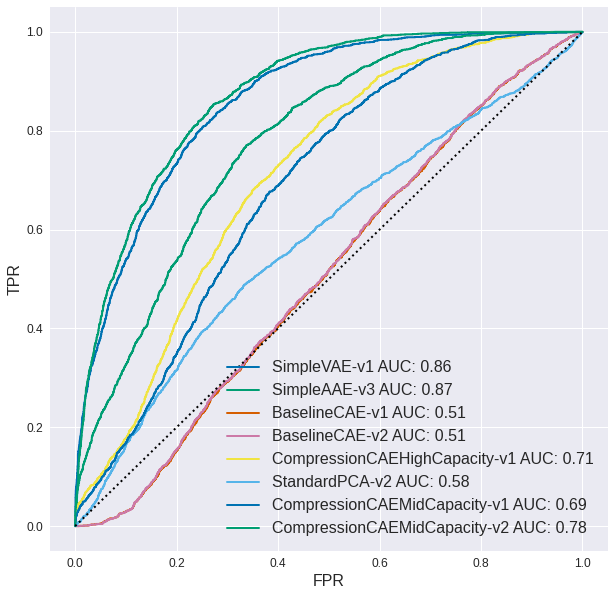

Random ROC AUC: 0.5


In [45]:
plt.figure(figsize=(10,10))
for sn, results in result_catalog.items():

    scores = results['scores']
    labels = results['labels']
    print(f'{sn}: {sum(scores)}')
    
    fpr, tpr, thresholds, auc = metrics.roc(scores, labels)
    
    plt.plot(fpr, tpr, lw=2., label=f'{sn} AUC: {auc:.2f}')
    
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.legend(fontsize=16)
plt.plot([0., 1.], [0., 1.], 'k:', lw=2, label='Random')
plt.show()
print('Random ROC AUC: 0.5')

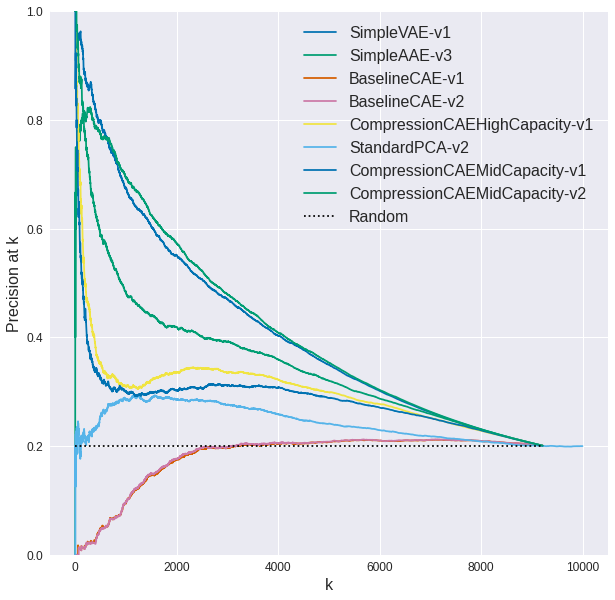

In [46]:
plt.figure(figsize=(10,10))
for sn, results in result_catalog.items():
    
    scores = results['scores']
    labels = results['labels']
    pak = metrics.precision_at_k(scores, labels)

    uniques, counts = np.unique(labels, return_counts=True)
    random = counts.min() / counts.sum()

    plt.plot(pak, label=f'{sn}')
    
plt.plot([0, len(pak)], [random, random], 'k:', label='Random')
plt.ylim([0., 1.])
plt.xlabel('k', fontsize=16)
plt.ylabel('Precision at k', fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

With the `result_catalog` everything that is needed to analyze and graph results from the archived models trained on Novelty MNIST are available and can be added below. New models that are created according to the system used above can be easily integrated into this experiment and tested in further steps.